In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration
from sklearn.preprocessing import MinMaxScaler
import scipy
import time
import multiprocessing

In [117]:
num_model_parameters = 3
num_strikes = 16
num_maturities = 16


num_input_parameters = 5
num_output_parameters = 1
learning_rate = 0.001
num_steps = 100
batch_size = 10
num_neurons = 5

#initial values
S0 = 1.0
V0 = 0.1
r = 0.05


contract_bounds = np.array([[0.6*S0,1.2*S0],[1,10]]) #bounds for K,T
model_bounds = np.array([[0.01,0.15],[0,1],[-1,0]]) #bounds for alpha,beta,rho, make sure alpha>0, beta,rho \in [0,1]

"""
Note: The grid of stirkes and maturities is equidistant here put could be choosen differently for real world application.
Note: For the code below to striktly follow the bounds specified above make sure that *_distance x num_* is less than half the distance from the highest to lowest * (* = strikes/maturities). 
"""
maturities_distance = (contract_bounds[1,1]-contract_bounds[1,0])/(2*num_maturities) 
strikes_distance = (contract_bounds[0,1]-contract_bounds[0,0])/(2*num_strikes)

strikes = np.linspace(contract_bounds[0,0],contract_bounds[0,0]+num_strikes*strikes_distance,num_strikes)
maturities = np.linspace(contract_bounds[1,0],contract_bounds[1,0]+num_maturities*maturities_distance,num_maturities)

In [118]:
X = tf.placeholder(tf.float32, [None, num_input_parameters])
y = tf.placeholder(tf.float32, [None, num_output_parameters])

In [123]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

def sabr(alpha,beta,T,W,Z,V0,S0):
    #print(beta)
    #assert(beta>0 and beta<1)

    def mu2(V,i,k):
        return 0.0
    
    def sigma2(V,i,k):
        return np.multiply(alpha,V)
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(V[i,k],np.power(np.maximum(0.0,S),beta))
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

def reverse_transform_X(X_scaled):
    X = np.zeros(X_scaled.shape)
    for i in range(num_model_parameters):
        X[:,i] = X_scaled[:,i]*(model_bounds[i][1]-model_bounds[i][0]) + model_bounds[i][0]
    for i in range(2):
        X[:,num_model_parameters+i] = X_scaled[:,num_model_parameters+i]*(contract_bounds[i][1]-contract_bounds[i][0]) + contract_bounds[i][0]
    return X

def price_pred(alpha,beta,rho,n,dim,T,K,V0,S0):
    W,Z = corr_brownian_motion(n,T,dim,rho)
    S,V = sabr(alpha,beta,T,W,Z,V0,S0)
    S_T = S[:,n]
    P = np.exp(-r*T) * np.mean(np.maximum(S_T-K,np.zeros(dim)))
    
    return P

def next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds):
    X_scaled = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))

    X_scaled[:,0] = uniform.rvs(size=batch_size) #alpha
    X_scaled[:,1] = uniform.rvs(size=batch_size) #beta
    X_scaled[:,2] = uniform.rvs(size=batch_size) #rho
    X_scaled[:,3] = uniform.rvs(size=batch_size) #maturities
    X_scaled[:,4] = uniform.rvs(size=batch_size) #strikes

    X = reverse_transform_X(X_scaled)

    n = 100
    dim = 200
    for i in range(batch_size):
        y[i,0] = price_pred(X[i,0],X[i,1],X[i,2],n,dim,X[i,3],X[i,4],V0,S0)

    return X_scaled,y

In [124]:
#Layers
hidden1 = fully_connected(X, num_neurons, activation_fn=tf.nn.elu)
bn1 = tf.nn.batch_normalization(hidden1, 0, 1, 0, 1, 0.000001)
hidden2 = fully_connected(bn1, num_neurons, activation_fn=tf.nn.elu)
bn2 = tf.nn.batch_normalization(hidden2, 0, 1, 0, 1, 0.000001)
hidden3 = fully_connected(bn2, num_neurons, activation_fn=tf.nn.elu)
bn3 = tf.nn.batch_normalization(hidden3, 0, 1, 0, 1, 0.000001)
hidden4 = fully_connected(hidden3, num_neurons, activation_fn=tf.nn.elu)
bn4 = tf.nn.batch_normalization(hidden4, 0, 1, 0, 1, 0.000001)

outputs = fully_connected(bn4, num_output_parameters, activation_fn=None)

In [125]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [126]:
num_cpu = multiprocessing.cpu_count()
config = tf.ConfigProto(device_count={ "CPU": num_cpu },
                                        inter_op_parallelism_threads=num_cpu,
                                        intra_op_parallelism_threads=2,
                                        )

with tf.Session(config=config) as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        
        X_batch,Y_batch = next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds)
        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        if iteration % 2 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
    
    saver.save(sess, "./models/sabr_dnn_m2")

0 	RMSE: 0.6367053
2 	RMSE: 0.6565906
4 	RMSE: 0.7660142
6 	RMSE: 0.62011194
8 	RMSE: 0.47249776
10 	RMSE: 0.564434
12 	RMSE: 0.597415
14 	RMSE: 0.32000637
16 	RMSE: 0.43296582
18 	RMSE: 0.5160165
20 	RMSE: 0.55272377
22 	RMSE: 0.2528978
24 	RMSE: 0.28401357
26 	RMSE: 0.21695754
28 	RMSE: 0.23423763
30 	RMSE: 0.20550747
32 	RMSE: 0.12445779
34 	RMSE: 0.25069192
36 	RMSE: 0.16229297
38 	RMSE: 0.21638997
40 	RMSE: 0.14487232
42 	RMSE: 0.1550846
44 	RMSE: 0.15770271
46 	RMSE: 0.15405317
48 	RMSE: 0.19424383
50 	RMSE: 0.14099428
52 	RMSE: 0.17469443
54 	RMSE: 0.17353955
56 	RMSE: 0.11351366
58 	RMSE: 0.16894302
60 	RMSE: 0.10207536
62 	RMSE: 0.15013614
64 	RMSE: 0.13261726
66 	RMSE: 0.12894586
68 	RMSE: 0.10207993
70 	RMSE: 0.19633822
72 	RMSE: 0.09916193
74 	RMSE: 0.07886098
76 	RMSE: 0.14619899
78 	RMSE: 0.1427849
80 	RMSE: 0.12599656
82 	RMSE: 0.123456165
84 	RMSE: 0.11215879
86 	RMSE: 0.06597837
88 	RMSE: 0.13923761
90 	RMSE: 0.09756007
92 	RMSE: 0.11235845
94 	RMSE: 0.10138961
96 	RMS

In [94]:
def predict_theta(prices_ture):   
    
    def NNprediction(theta,maturities,strikes):
        res = np.zeros((1,num_maturities,num_strikes))
        x = np.zeros((1,num_input_parameters))
        
        x[0,0:3] = theta
       
        for i in range(num_maturities):
            for j in range(num_strikes):
                x[0,3] = maturities[i]
                x[0,4] = strikes[j]
                res[0,i,j] = sess.run(outputs,feed_dict={X: x})
        return res
    def NNgradientpred(theta,maturities,strikes):
        x = np.zeros((1,num_input_parameters))
        
        x[0,0:3] = theta
       
        grad = np.zeros((num_model_parameters,num_maturities,num_strikes))
        
        delta = 0.000001
        for i in range(num_model_parameters):
            h = np.zeros((1,num_input_parameters))
            h[0,i] = delta
            for j in range(num_maturities):
                for k in range(num_strikes):
                    x[0,3] = maturities[j]
                    x[0,4] = strikes[k]
                    #two point gradient
                    #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

                    #four point gradient
                    grad[i,j,k] = (-sess.run(outputs,feed_dict={X: x+2*h})+8*sess.run(outputs,feed_dict={X: x+h})-8*sess.run(outputs,feed_dict={X: x-h}) +sess.run(outputs,feed_dict={X: x-2*h}))/12/delta

        return np.mean(np.mean(grad,axis=1),axis=1)

    def CostFuncLS(theta,maturities,strikes):
        
        return np.sqrt(np.mean(np.mean(np.power((NNprediction(theta,maturities,strikes)-prices_true)[0],2),axis=0),axis=0))


    def JacobianLS(theta,maturities,strikes):

        return NNgradientpred(theta,maturities,strikes)

    with tf.Session() as sess:                          
        saver.restore(sess, "./models/sabr_dnn_m2")      
        
        init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
        bnds = ([model_bounds[0,0],model_bounds[1,0],model_bounds[2,0]],[model_bounds[0,1],model_bounds[1,1],model_bounds[2,1]])


        I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,bounds=bnds,gtol=1E-15,xtol=1E-15,verbose=1,args=(maturities,strikes))

    theta_pred = I.x
    
    return theta_pred

In [95]:
def prices_grid(theta):
    prices_true = np.zeros((1,num_maturities,num_strikes))
    n = 100
    dim = 200
    for i in range(num_maturities):
        for j in range(num_strikes):        
            prices_true[0,i,j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
    return prices_true

In [96]:
theta_true = [0.1,0.5,-0.5]
prices_true = prices_grid(theta_true)

In [97]:
theta_pred = predict_theta(prices_true)

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_m2
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 1.0376e-01, final cost 1.0376e-01, first-order optimality 9.55e-03.


In [98]:
print(theta_true)
print(theta_pred)

[0.1, 0.5, -0.5]
[ 0.04582458  0.78066875 -0.69993229]


In [99]:
prices_true = np.zeros((num_maturities,num_strikes))
prices_pred = np.zeros((num_maturities,num_strikes))
init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
prices_trash = np.zeros((num_maturities,num_strikes))
n = 100
dim = 300
for i in range(num_maturities):
    for j in range(num_strikes):        
        prices_true[i,j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_pred[i,j] = price_pred(theta_pred[0],theta_pred[1],theta_pred[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_trash[i,j] = price_pred(init[0],init[1],init[2],n,dim,maturities[i],strikes[j],V0,S0)

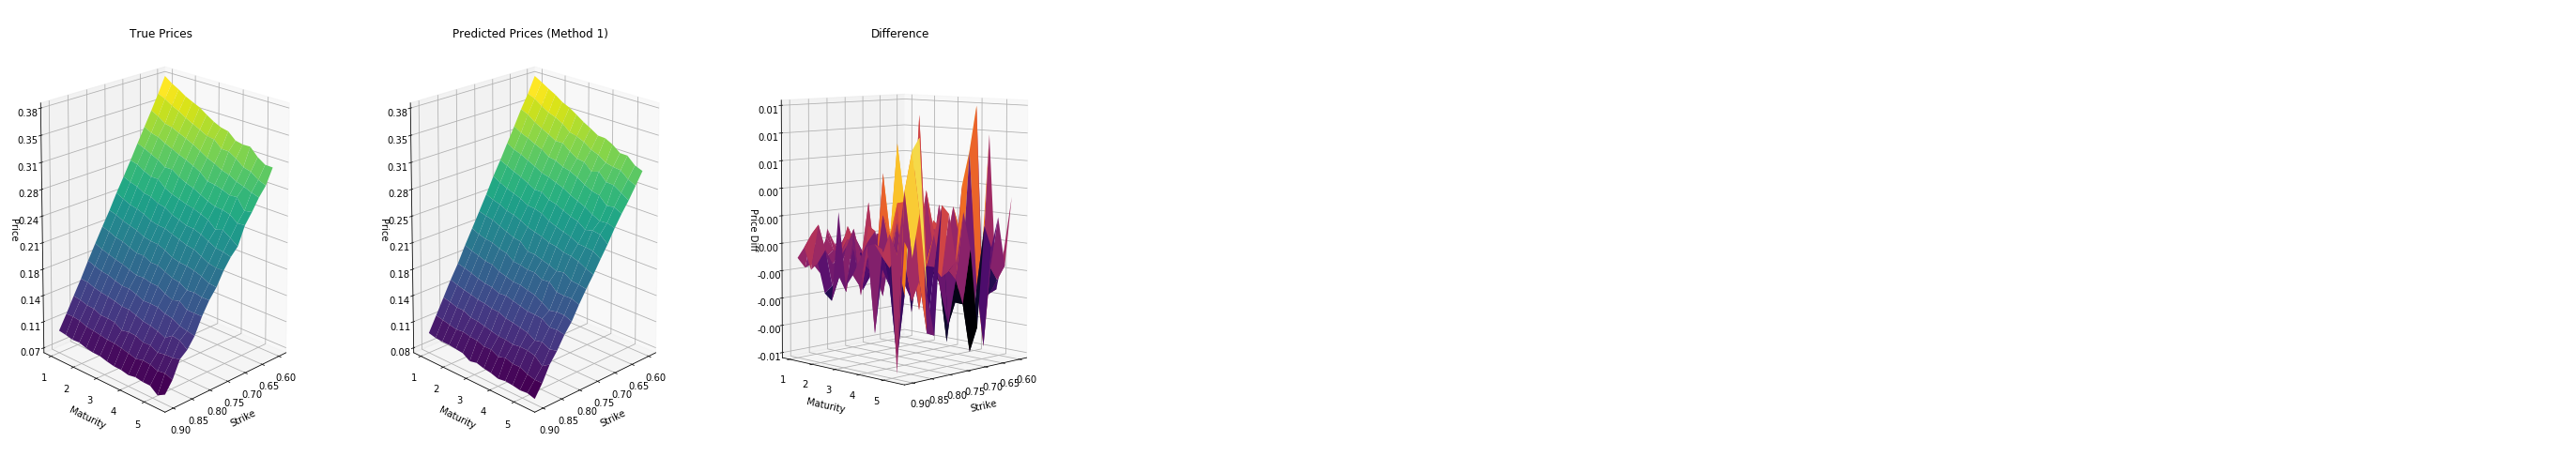

In [100]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(20, 9))

T_ = np.zeros((num_maturities,num_strikes))
K_ = np.zeros((num_maturities,num_strikes))
for i in range(num_strikes):
    for j in range(num_maturities):
        T_[j,i] = maturities[j]
for j in range(num_maturities):   
    for i in range(num_strikes):
        K_[j,i] = strikes[i]

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X=K_, Y=T_, Z=prices_true, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')
ax1.set_title('True Prices')
ax1.view_init(15, 45)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=prices_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices (Method 1)')
ax2.view_init(15, 45)


ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=prices_true-prices_pred, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity')
ax3.set_zlabel('Price Diff')
ax3.set_title('Difference')
ax3.view_init(5, 45)
"""
ax3 = fig.add_subplot(133)
ax3.imshow(prices_true-prices_pred,cmap='Blues_r')
ax3.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax3.set_xticklabels(np.around(strikes,decimals=1))
ax3.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax3.set_yticklabels(np.around(maturities,decimals=1))
"""
plt.savefig('prices_dnn_m2.pdf') 
plt.show()

In [101]:
mean_err = np.mean(np.mean(np.abs(prices_true-prices_pred),axis=0),axis=0)
mean_err_init = np.mean(np.mean(np.abs(prices_true-prices_trash),axis=0),axis=0)
mean_true_price = np.mean(np.mean(np.abs(prices_true),axis=0),axis=0)
print("MSE: ",mean_err)
print("MSE Init: ",mean_err_init)
print("Percent of avg True Price: ",mean_err/mean_true_price*100)

MSE:  0.0017048306487630273
MSE Init:  0.0016604925423661528
Percent of avg True Price:  0.7991983981659876
